# Install and import

In [ ]:
!pip install git+https://github.com/KevinMusgrave/pytorch-metric-learning
!pip install -q faiss-gpu
!pip install -q umap-learn
!pip install -q pynndescent
!pip install -q record-keeper

  Cloning https://github.com/KevinMusgrave/pytorch-metric-learning to /tmp/pip-req-build-jatsr32s
  Running command git clone -q https://github.com/KevinMusgrave/pytorch-metric-learning /tmp/pip-req-build-jatsr32s
  Created wheel for pytorch-metric-learning: filename=pytorch_metric_learning-0.9.89.dev1-cp36-none-any.whl size=84125 sha256=84e1ece15f5e7ab2f4431fe5777b1fcb07a6ba45a48240a795942db27ef9f70a
  Stored in directory: /tmp/pip-ephem-wheel-cache-4c1t3f0f/wheels/3c/b5/f0/d921c1181ab3df8077d18e8fa111e0d14f304f4bfb33fa1a74
Successfully built pytorch-metric-learning
     |████████████████████████████████| 35.5MB 88kB/s 
     |████████████████████████████████| 1.1MB 2.7MB/s 


In [ ]:
%matplotlib inline
from tqdm import trange
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import os
from torchvision.datasets.folder import default_loader
import datetime


logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)
    

INFO:root:VERSION 0.9.89.dev1


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

## Transforms

In [ ]:
# Set the image transforms
train_transform = transforms.Compose([transforms.Resize((64,64)),
                                    transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=64),
                                    transforms.RandomHorizontalFlip(0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize((64,64)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


## CUB-2011 dataset and class-disjoint train/val splits

In [ ]:
!wget https://raw.githubusercontent.com/TDeVries/cub2011_dataset/master/cub2011.py

--2020-07-09 08:03:16--  https://raw.githubusercontent.com/TDeVries/cub2011_dataset/master/cub2011.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘cub2011.py’

cub2011.py          100%[===================>]   2.84K  --.-KB/s    in 0s      

2020-07-09 08:03:16 (35.7 MB/s) - ‘cub2011.py’ saved [2904/2904]



In [ ]:
from cub2011 import Cub2011

In [ ]:
original_train = Cub2011(root="CUB2011", train=True, transform=None, download=True)
original_val = Cub2011(root="CUB2011", train=False, transform=None, download=True)

Files already downloaded and verified


In [ ]:
n_classes = max(max(original_train.data.target), max(original_val.data.target))
n_classes

200

In [ ]:
class ClassDisjointDataSet(torch.utils.data.Dataset):
    def __init__(self, original_train, original_val, train, split_point=0.5, n_classes=100, transform=None):
        self.original_train = original_train
        self.original_val = original_val

        split_class = round(split_point*n_classes)
        rule = (lambda x: x < split_class) if train else (lambda x: x >=split_class)
        train_filtered_idx = [i for i,x in enumerate(original_train.data.target) if rule(x)]
        val_filtered_idx = [i for i,x in enumerate(original_val.data.target) if rule(x)]
        
        train_fpaths = original_train.data.iloc[train_filtered_idx].apply(
            lambda x: os.path.join(self.original_train.root, self.original_train.base_folder, x.filepath),
            axis=1
        )
        val_fpaths = original_val.data.iloc[val_filtered_idx].apply(
            lambda x: os.path.join(self.original_val.root, self.original_val.base_folder, x.filepath),
            axis=1
        )

        self.img_paths = np.concatenate([train_fpaths, val_fpaths])
        self.data = np.concatenate([original_train.data.iloc[train_filtered_idx], original_val.data.iloc[val_filtered_idx]], axis=0)
        self.targets = np.concatenate([np.array(original_train.data.target)[train_filtered_idx], np.array(original_val.data.target)[val_filtered_idx]], axis=0)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):            
        path, target = self.img_paths[index], self.targets[index]
        img = default_loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

train_dataset = ClassDisjointDataSet(original_train, original_val, True, n_classes=n_classes, transform=train_transform)
val_dataset = ClassDisjointDataSet(original_train, original_val, False, n_classes=n_classes, transform=val_transform)
assert set(train_dataset.targets).isdisjoint(set(val_dataset.targets))

# Prepare for training

## Model

In [ ]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

In [ ]:
# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet18(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 64]).to(device))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


## Optimizers

In [ ]:
# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.0001, weight_decay=0.0001)

##Create the loss, miner, sampler, and package them into dictionaries


In [ ]:
loss = losses.TripletMarginLoss(margin=0.1)

miner = miners.MultiSimilarityMiner(epsilon=0.1)

sampler = samplers.MPerClassSampler(train_dataset.targets, m=4, length_before_new_iter=len(train_dataset))


# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

## Create the trainer

In [ ]:
# Remove logs if you want to train with new parameters
#!rm -rf example_logs/ example_saved_models/ example_tensorboard/

In [ ]:
batch_size = 32
num_epochs = 10

In [ ]:
experiment_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
record_keeper, _, _ = logging_presets.get_record_keeper(experiment_id, "tensorboard")
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": val_dataset}
model_folder = experiment_id

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
    label_set = np.unique(labels)
    num_classes = len(label_set)
    fig = plt.figure(figsize=(20,15))
    plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)   
    plt.show()

# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                            visualizer = umap.UMAP(), 
                                            visualizer_hook = visualizer_hook,
                                            dataloader_num_workers = 32)

end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_folder, 
                                            test_interval = 1,
                                            patience = 1)

In [ ]:
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers = 32,
                                end_of_iteration_hook = hooks.end_of_iteration_hook,
                                end_of_epoch_hook = end_of_epoch_hook)

# Train the model

In [ ]:
%tensorboard --logdir tensorboard

<IPython.core.display.Javascript object>

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1

total_loss=0.11652: 100%|██████████| 173/173 [00:45<00:00,  3.82it/s]
INFO:root:Evaluating epoch 1
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:36<00:00,  5.16it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


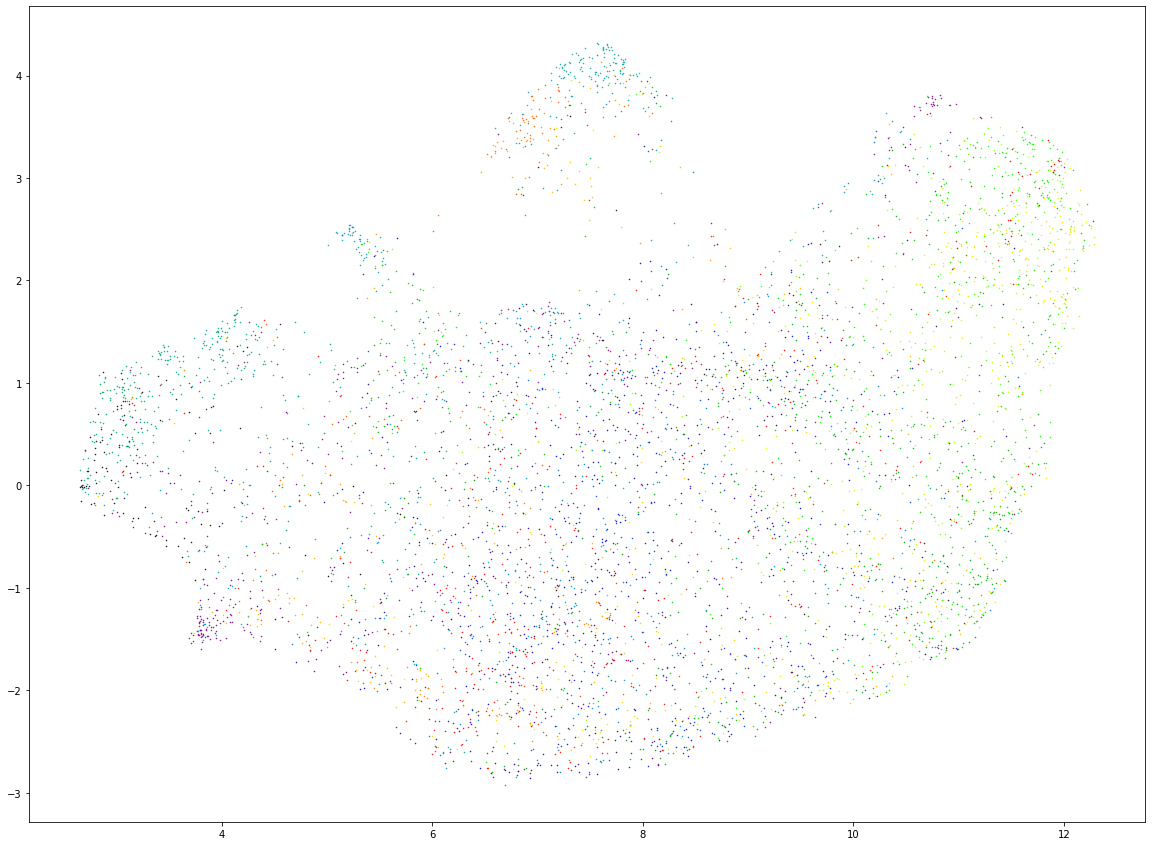

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy! 0.021670493777770597
INFO:root:TRAINING EPOCH 2

total_loss=0.10668: 100%|██████████| 173/173 [00:48<00:00,  3.60it/s]
INFO:root:Evaluating epoch 2
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:35<00:00,  5.21it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


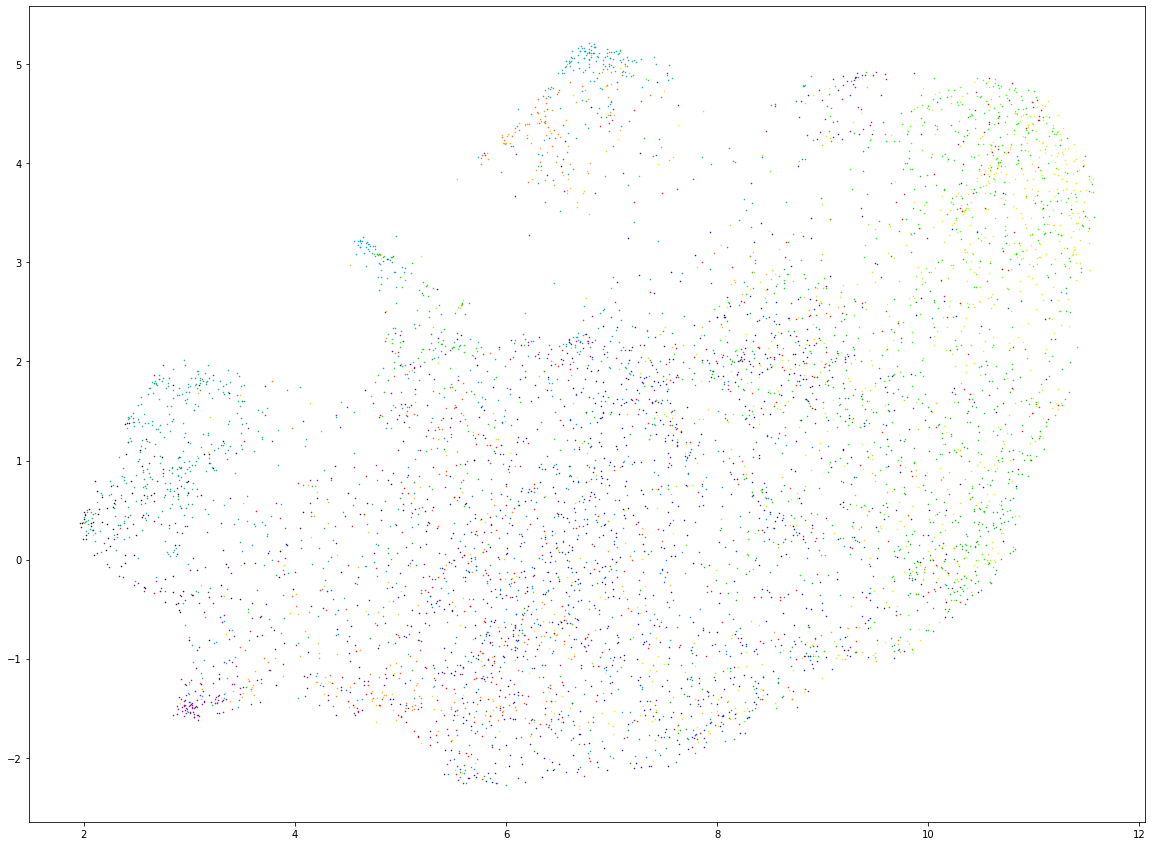

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy! 0.02234412238462418
INFO:root:TRAINING EPOCH 3

total_loss=0.09728: 100%|██████████| 173/173 [00:47<00:00,  3.63it/s]
INFO:root:Evaluating epoch 3
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:36<00:00,  5.19it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


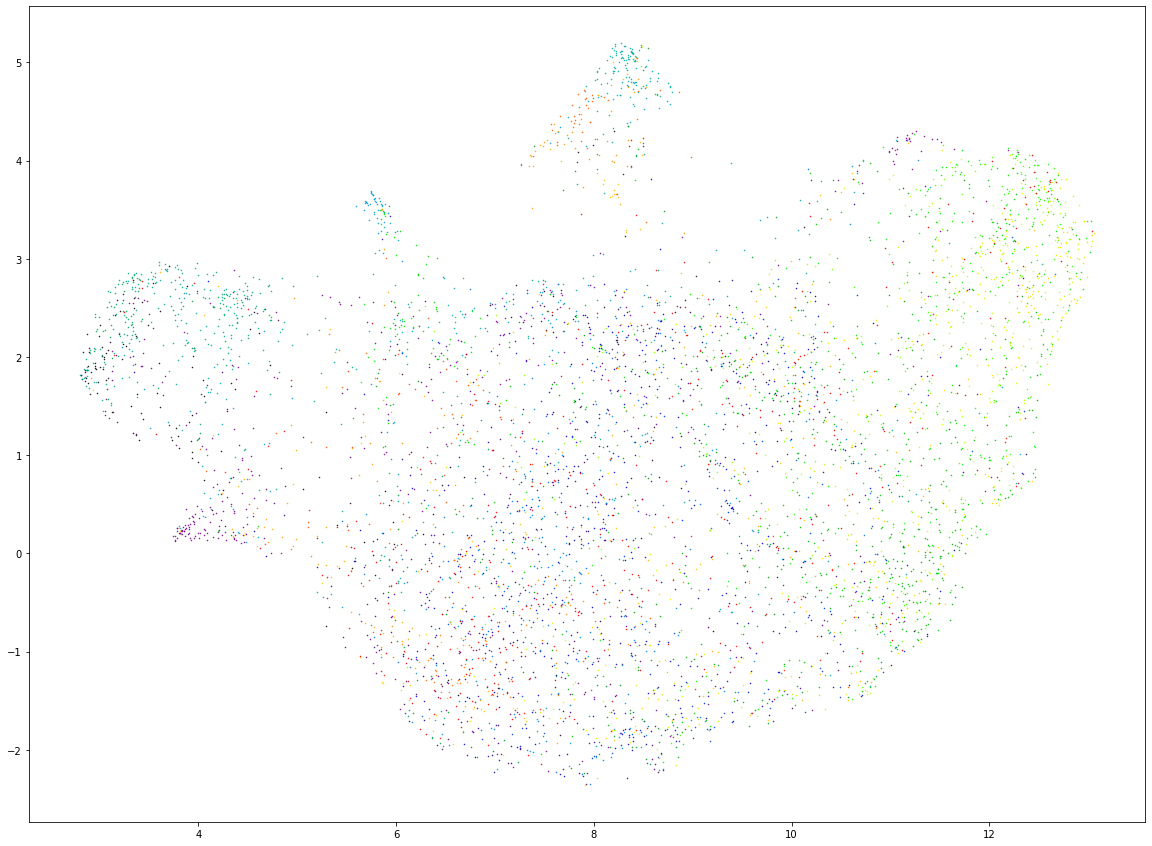

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:TRAINING EPOCH 4

total_loss=0.11807: 100%|██████████| 173/173 [00:48<00:00,  3.60it/s]
INFO:root:Evaluating epoch 4
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:35<00:00,  5.33it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


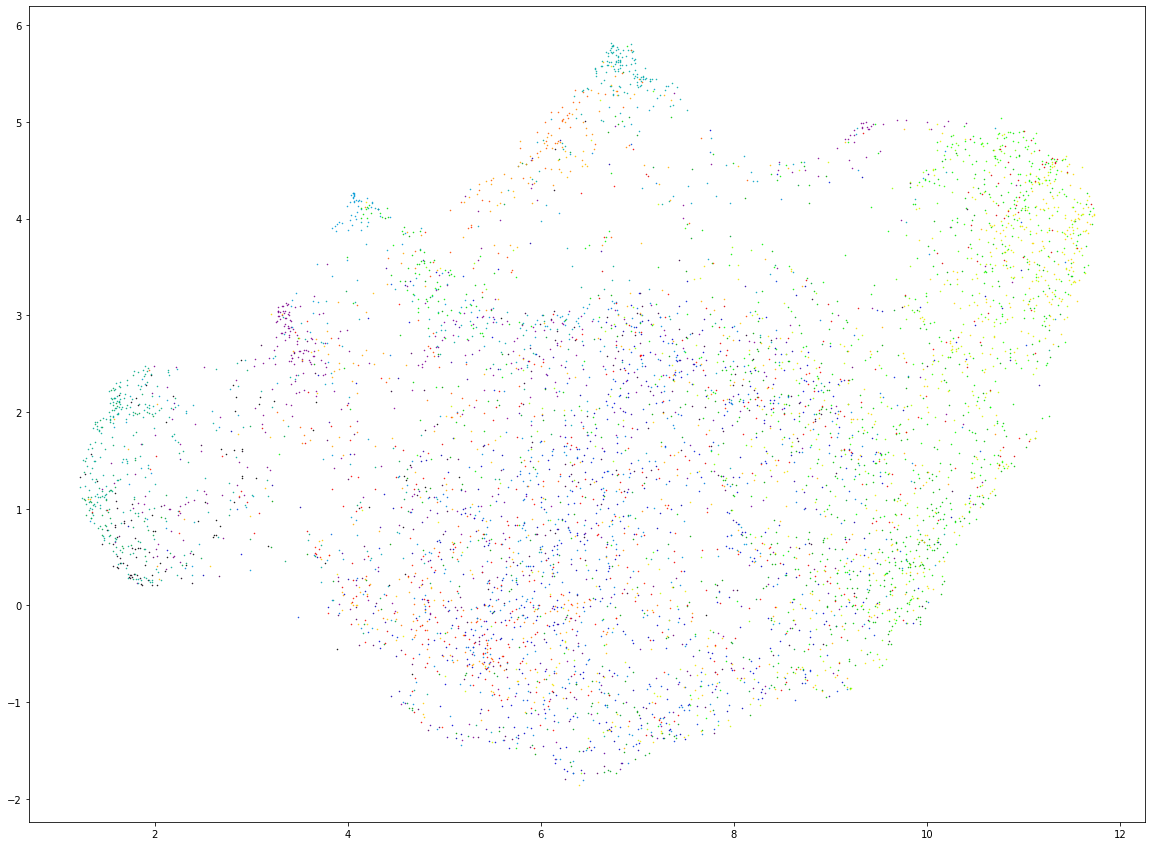

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy! 0.02356846161776423
INFO:root:TRAINING EPOCH 5

total_loss=0.11784: 100%|██████████| 173/173 [00:48<00:00,  3.59it/s]
INFO:root:Evaluating epoch 5
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:36<00:00,  5.15it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


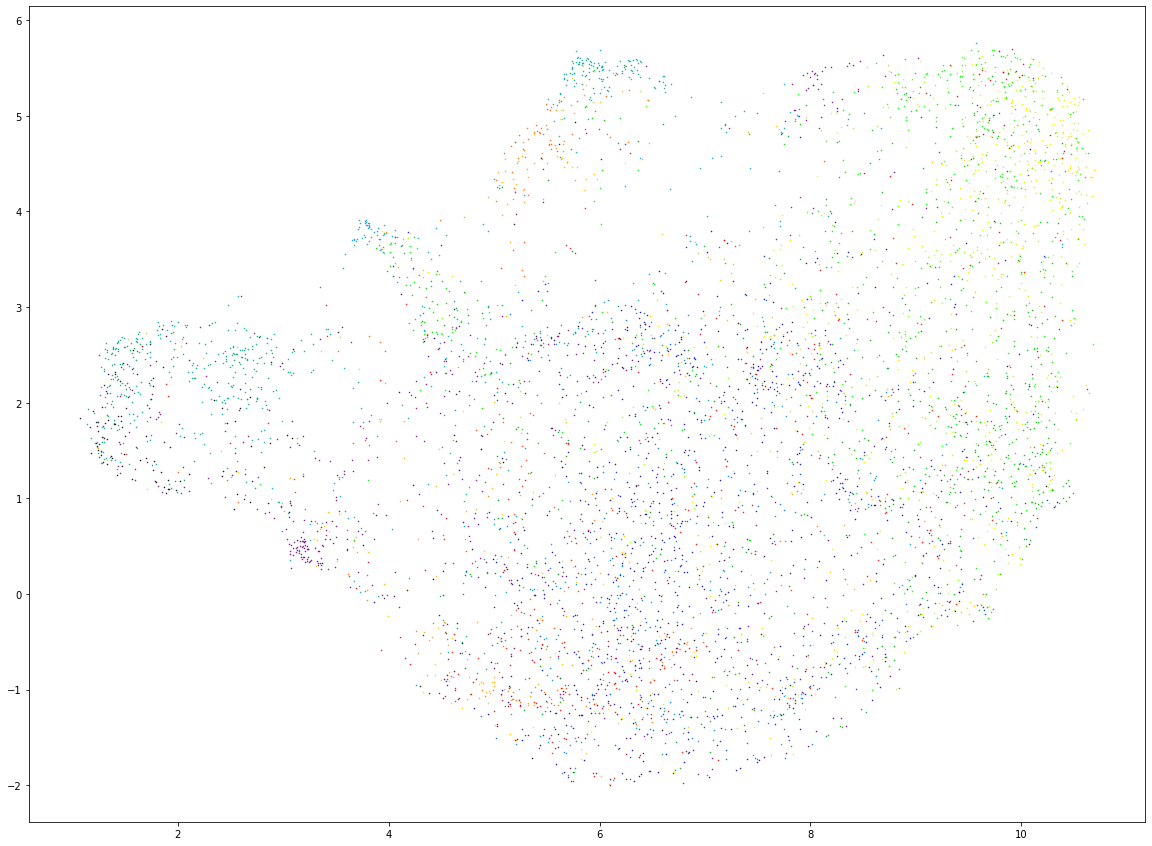

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy! 0.025054964773524997
INFO:root:TRAINING EPOCH 6

total_loss=0.11356: 100%|██████████| 173/173 [00:47<00:00,  3.65it/s]
INFO:root:Evaluating epoch 6
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:34<00:00,  5.35it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


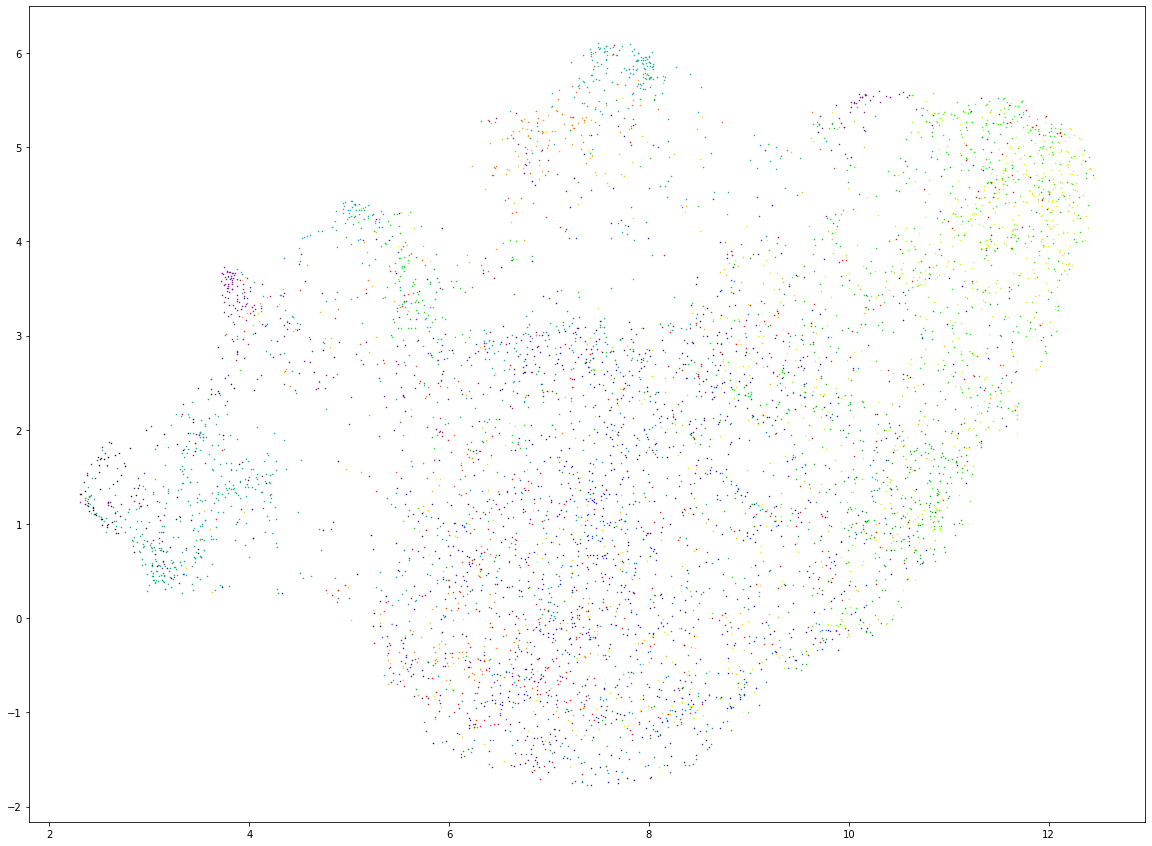

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:TRAINING EPOCH 7

total_loss=0.12247: 100%|██████████| 173/173 [00:47<00:00,  3.61it/s]
INFO:root:Evaluating epoch 7
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:34<00:00,  5.35it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


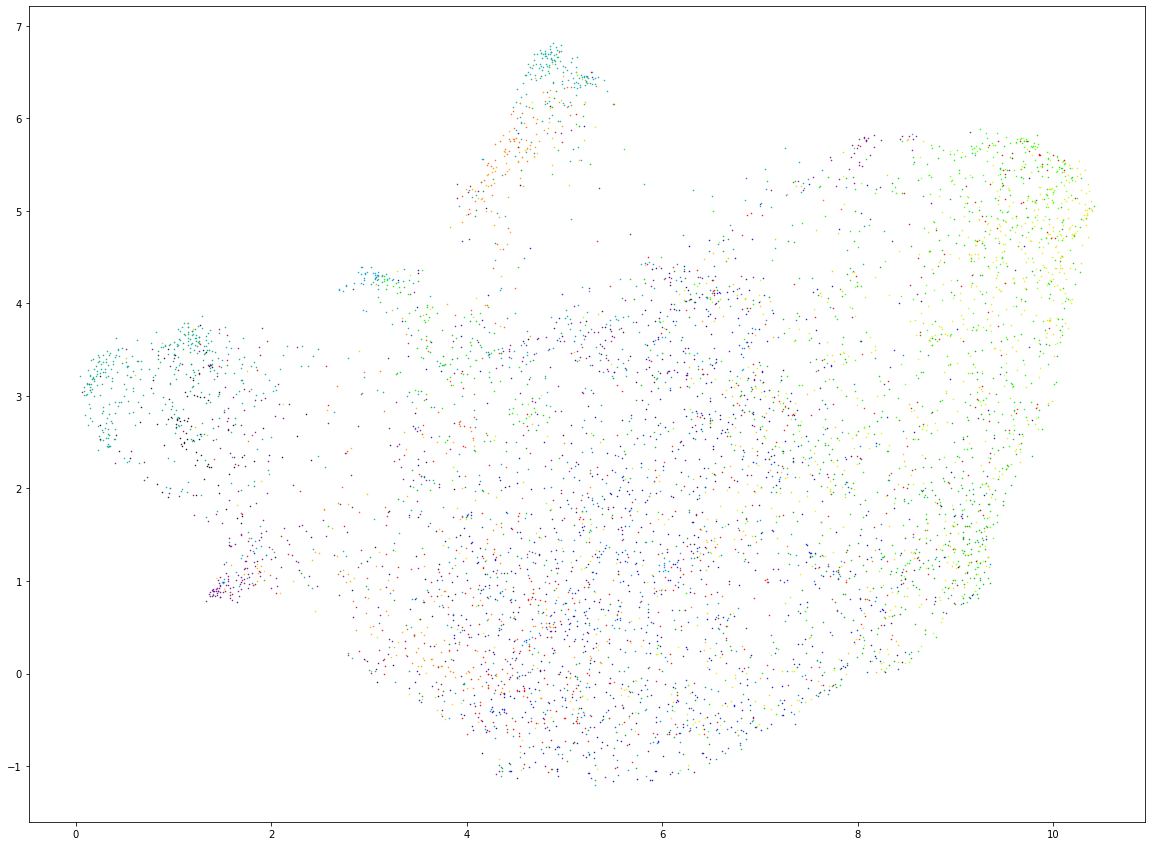

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy! 0.025061181053920172
INFO:root:TRAINING EPOCH 8

total_loss=0.10461: 100%|██████████| 173/173 [00:47<00:00,  3.65it/s]
INFO:root:Evaluating epoch 8
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:34<00:00,  5.39it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


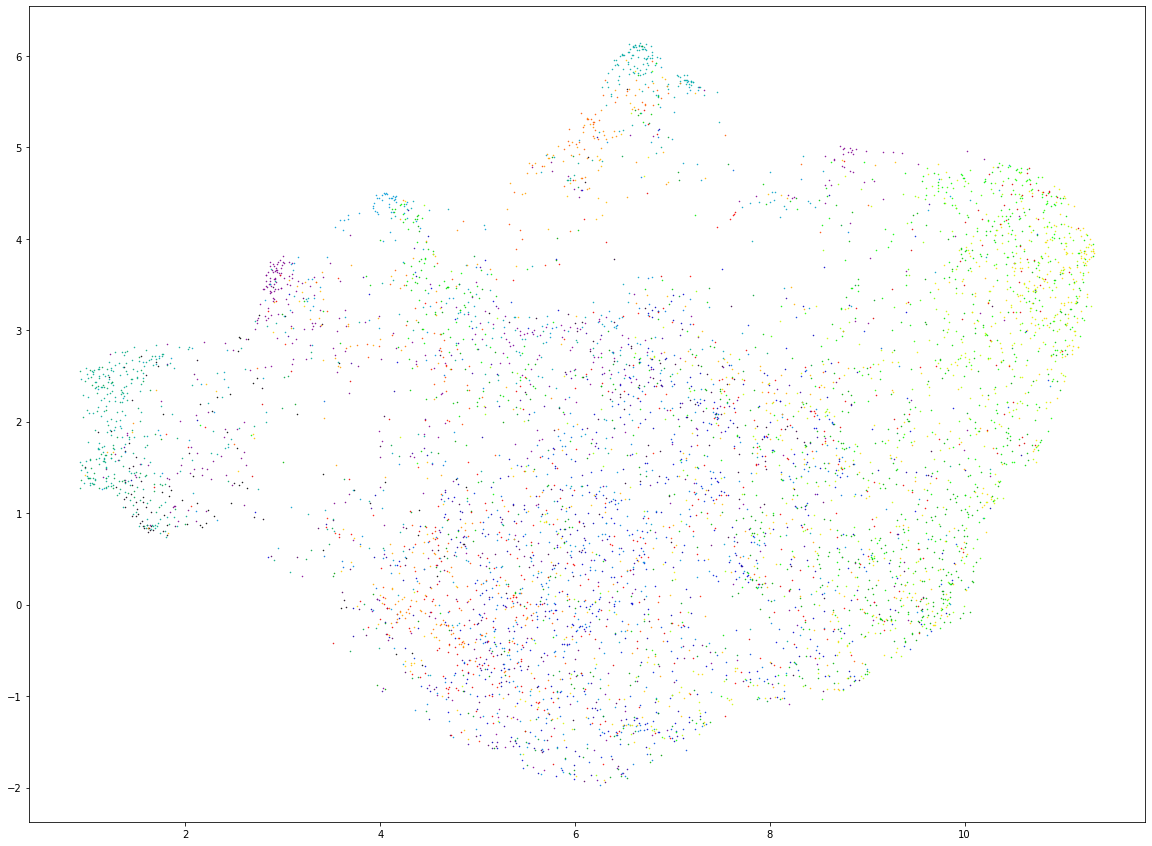

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy! 0.025441830488864888
INFO:root:TRAINING EPOCH 9

total_loss=0.11055: 100%|██████████| 173/173 [00:47<00:00,  3.65it/s]
INFO:root:Evaluating epoch 9
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:34<00:00,  5.42it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


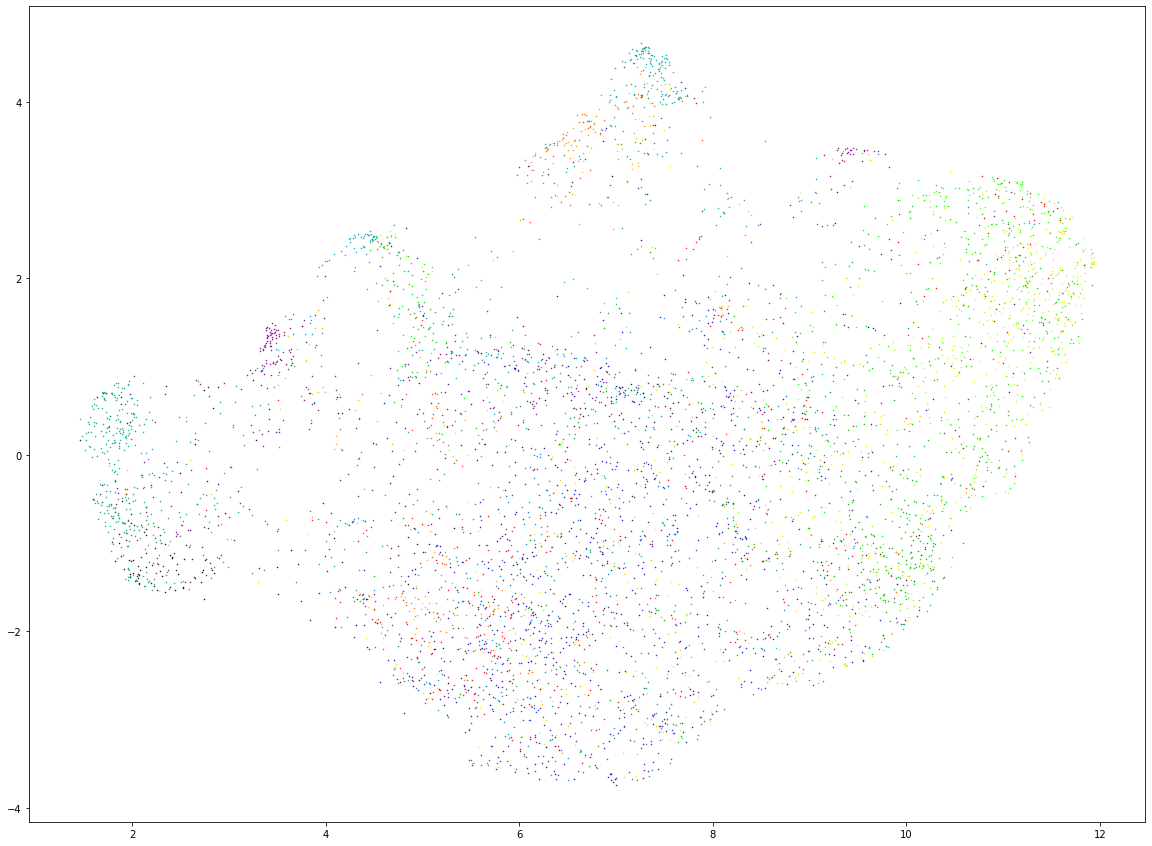

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy! 0.026164029141496226
INFO:root:TRAINING EPOCH 10

total_loss=0.11655: 100%|██████████| 173/173 [00:47<00:00,  3.66it/s]
INFO:root:Evaluating epoch 10
INFO:root:Getting embeddings for the val split

100%|██████████| 187/187 [00:35<00:00,  5.33it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


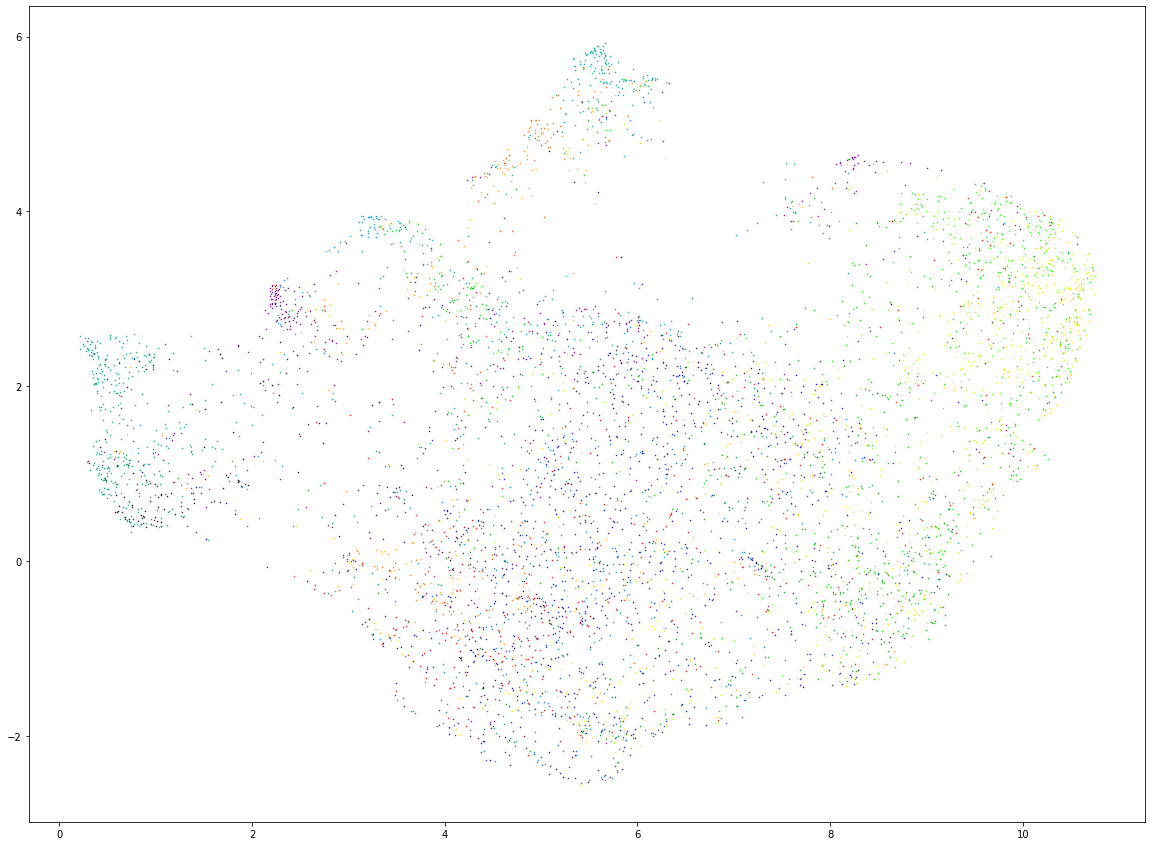

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 64


In [ ]:
trainer.train(num_epochs=num_epochs)

# Evaluate results

In [ ]:
match_finder = MatchFinder(mode="sim", threshold=0.7)
inference_model = InferenceModel(models['trunk'], embedder=models['embedder'], match_finder=match_finder)

## Visual evaluation

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataset = val_dataset


In [ ]:
class_a = dataset.targets[0]
class_b = dataset.targets[100]

class_a_idx = (dataset.targets == class_a).nonzero()[0]
class_b_idx = (dataset.targets == class_b).nonzero()[0]

In [ ]:
class_a_idx[:10], class_b_idx[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

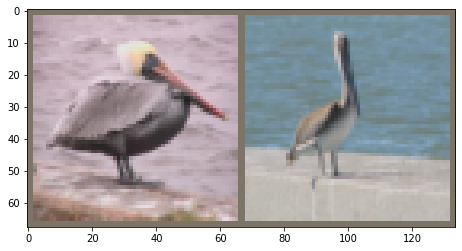

Different class


In [ ]:
# compare two images of the same class
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_a_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

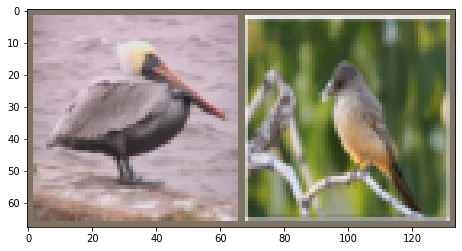

Different class


In [ ]:
# compare two images of different classes
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_b_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

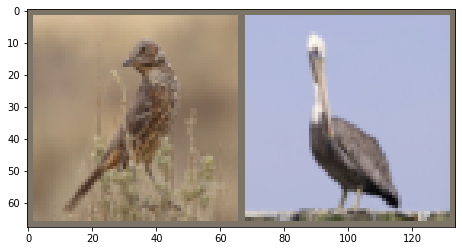

Different class


In [ ]:
# compare two random images
idx1 = np.random.choice(range(len(dataset)))
idx2 = np.random.choice(range(len(dataset)))
(x, _), (y, _) = dataset[idx1], dataset[idx2]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

## Evaluation datasets

In [ ]:
gallery_dataset = ClassDisjointDataSet(original_train, original_val, True, n_classes=n_classes, transform=val_transform)
query_dataset = ClassDisjointDataSet(original_train, original_val, False, n_classes=n_classes, transform=val_transform)

inference_model.train_indexer([gallery_dataset[i][0] for i in range(len(gallery_dataset))], 64)

In [ ]:
len(gallery_dataset), len(query_dataset)

(5804, 5984)

In [ ]:
def get_many_embeddings(tensors, inference_model, batch_size=128, emb_dim=64):
    embeddings = torch.Tensor(len(tensors), emb_dim)
    for i in range(0, len(tensors), batch_size):
        embeddings[i:i + batch_size] = inference_model.get_embeddings(tensors[i:i + batch_size], None)[0]
    return embeddings

gallery_embeddings = get_many_embeddings([gallery_dataset[i][0] for i in range(len(gallery_dataset))], inference_model)
query_embeddings = get_many_embeddings([query_dataset[i][0] for i in range(len(query_dataset))], inference_model)

## Scores

In [ ]:
gallery_labels = gallery_dataset.targets
query_labels = query_dataset.targets


calculator = AccuracyCalculator()
acc_dict = calculator.get_accuracy(gallery_embeddings.numpy(),
    gallery_embeddings.numpy(),
    gallery_labels,
    gallery_labels,
    embeddings_come_from_same_source=True
)

acc_dict

INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 64


{'AMI': 0.37322169735416916,
 'NMI': 0.49042143198320104,
 'mean_average_precision_at_r': 0.05844533034354256,
 'precision_at_1': 0.24776016540317022,
 'r_precision': 0.15176511460953082}

## Retrieval

[[1.6145945e-12 9.0077065e-02 9.4062820e-02 1.0271574e-01 1.0584841e-01]]


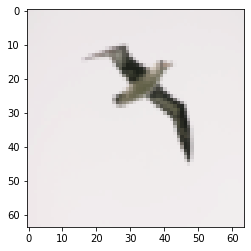

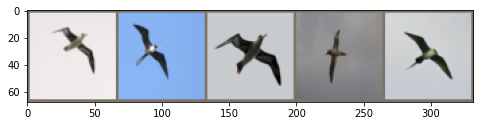

Query label 2
Neighbor labels [ 2 44  2  3 71]


In [ ]:
k = 5
query_idx = 51
query_img = gallery_dataset[query_idx][0]
query_batch =  [query_img]
# D, I = index.search(query_batch, k)
# print(D)

I, D = inference_model.get_nearest_neighbors(query_batch, k=k)
print(D)
neighbors_idx = I[0]
neighbors_imgs = [gallery_dataset[i][0] for i in neighbors_idx]
neighbors_labels = gallery_dataset.targets[neighbors_idx]

imshow(query_img)

imshow(torchvision.utils.make_grid(torch.stack(neighbors_imgs, dim=0)))
print('Query label', gallery_dataset.targets[query_idx])
print('Neighbor labels', neighbors_labels)